## Задача 1.4
[Выборка: новости Lenta.ru](https://github.com/yutkin/Lenta.Ru-News-Dataset)

1. Взять случайную подвыборку новостей lenta.ru за 2019 год (не менее 3000)
2. На основе подвыборки построить граф связей упоминания личностей, организаций и стран из [списка](entities.txt).
3. В новостях выбрать сущность, зависящую от наибольшего количества других сущностей (далее будем называть ее центральной)
4. посчитать ACE уопминания центральной сущности при упоминании (и отсутствии упоминания) сущностей, от которых она зависит
5. сравнить результаты пункта 4 с оценками вероятностей упоминания центральной сущности при условии упоминания (и при отсутствии упоминания) сущностей, от которых она зависит

**Рекомендации: (в случае использования пакета causality):**

1. в качестве теста для проверки условной независимости использовать MutualInformationTest
2. результаты будут сильно отличаться в зависимости от полученной случаной подвыборки. Фиксируйте seed.
3. для учета разного написания сущности (число, род, падеж) используйте методы стеминга (nltk.stem или mystem):
https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text
4. causality не умеет работать с циклами (но сам их производит). Циклы можно удалять (в этой лабе, в реальности нельзя).

### Данные

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns

import networkx as nx
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib import gridspec
%matplotlib inline
mpl.style.use('seaborn')

from statsmodels.regression.linear_model import OLS

from causalgraphicalmodels import CausalGraphicalModel
from causality.inference.search import IC
from causality.inference.independence_tests import MutualInformationTest
from causality.estimation.adjustments import AdjustForDirectCauses
from causality.estimation.nonparametric import CausalEffect

In [2]:
datapath = './lenta-ru-news.csv'
data = pd.read_csv(datapath, low_memory=False)
print(data.shape)
data.head()

(800975, 6)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


Список сущностей из предложенного списка:

In [4]:
entities_set = []
with open('./entities.txt') as fp:
    line = fp.readline()
    while line:
        entities_set.append(line.rstrip('\n'))
        line = fp.readline()
        
print(entities_set)

['украина', 'сша', 'россия', 'москва', 'киев', 'тасс', 'трамп', 'риа', 'донбасс', 'европа', 'порошенко', 'зеленский', 'путин', 'крым', 'мвд', 'сирия', 'турция', 'германия', 'петербург', 'интерфакс', 'великобритания']


Посмотрим на существующие теги и топики. Видно, что они не сильно помогут нам в задаче, так что в будущем уберем их за ненадобностью

In [5]:
print(set(data['topic'].values))
print('-'*40)
print(set(data['tags'].values))

{nan, 'Сочи', 'МедНовости', 'Библиотека', 'Бывший СССР', 'Дом', 'Оружие', 'Легпром', 'Спорт', 'Культура', 'Путешествия', 'ЧМ-2014', '69-я параллель', 'Силовые структуры', 'Экономика', 'Культпросвет ', 'Бизнес', 'Из жизни', 'Интернет и СМИ', 'Россия', 'Крым', 'Наука и техника', 'Ценности', 'Мир'}
----------------------------------------
{nan, 'Вирусные ролики', 'Реклама', 'Инновации', 'Прибалтика', 'Летние виды', 'Игры', 'Достижения', 'Хоккей', 'Преступная Россия', 'Культура', 'Криминал', 'Пресса', 'Бизнес', 'Финансы компаний', 'Стиль', 'Coцсети', 'Искусство', 'Закавказье', 'ТВ и радио', 'Производители', 'Экология', 'Английский футбол', 'Происшествия', 'Молдавия', 'Рынки', 'Жизнь', 'Футбол', 'Деловой климат', 'Квартира', 'Казахстан', 'Нацпроекты', 'Инструменты', 'Кино', 'Книги', 'Деньги', 'Люди', 'Мнения', '69-я параллель', 'Следствие и суд', 'Политика', 'Мемы', 'Космос', 'Движение', 'Часы', 'Социальная сфера', 'Автобизнес', 'Мир', 'Дача', 'Страноведение', 'События', 'Средняя Азия', 'Те

Возьмем сэмпл 4000 случайных новостей. Заодно уберем неинформативные столбцы topic, tags, url и date

In [6]:
data_sample = data.sample(n=4000, random_state=42)[['title', 'text']]
data_sample

,title,text
264350,Жена Оззи Осборна выиграла суд против британск...,Жена лидера британской группы Black Sabbath Оз...
283172,В Осло вручили международную премию Абеля по м...,"Международная Абелевская премия, учрежденная в..."
151377,Сбивший полицейского российский дипломат покин...,28-летний российский атташе при ООН Илья Мороз...
385650,Рен ТВ сменил слоган и эфирное оформление,Телеканал Рен ТВ официально объявил о смене эф...
479714,Госдуме предложили не пускать в Россию мигрант...,Депутаты законодательного собрания Санкт-Петер...
...,...,...
619532,«Енисей» выбил ЦСКА из розыгрыша Кубка России,Красноярский «Енисей» под руководством Андрея ...
601736,Фигуристка Сотникова ушла из Instagram из-за н...,"Российская фигуристка, олимпийская чемпионка С..."
217087,По итогам супервторника Клинтон получила еще о...,В США закончились подсчеты результатов голосов...
754856,Россия признала власть устроивших переворот в ...,Москва признает новые власти Судана. Об этом з...


### Предобработка текста

In [7]:
import pymorphy2
import nltk
import re
from tqdm import tqdm

nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to /Users/Pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В качестве предобработки будет действовать по следующему алгоритму. Убираем пунктуацию, числа и "мусорные" символы. Далее токенизируем слова, убираем стоп-слова. Далее у оставшихся токенов слов берем нормальную форму слова. Возможно после приведения к нормальной форме появятся снова стоп-слова, так что еще раз проверим на стоп-слова. Для каждого резултата будем оставлять только слова, которые есть в списке сущностей entities_set.

In [8]:
def text_prepare(text, entities=False):

    stop_words = set(stopwords.words('russian'))
    lemmatizer = pymorphy2.MorphAnalyzer()
        
    text = re.sub(r'[^\w\s]','', text.lower()) # убираем пунктуацию и мусор
    text = re.sub(r'[0-9]','', text) # убираем числа
        
    word_tokens = word_tokenize(text) # токенизируем слова
    word_tokens = [w for w in word_tokens if not w in stop_words] # убираем стоп-слова
    raw_words = [lemmatizer.parse(w)[0].normal_form for w in word_tokens] # оставляем нормальные формы слов
    clean_words = [w for w in raw_words if not w in stop_words] # еще разок уберем стоп-слова, вдруг появиись :)
        
    if entities:
        entities = list(set([w for w in clean_words if w in entities_set]))
        return entities
    
    filtered_text = ' '.join(clean_words)
    return filtered_text

Пример преобразования текста

In [18]:
print('Оригинальный текст: {}'.format(data_sample['title'].values[-17]))
print('Преобразованный текст: {}'.format(text_prepare(data_sample['title'].values[-17])))
print('Сущности из преобразованного текста: {}'.format(text_prepare(data_sample['title'].values[-17], entities=True)))

Оригинальный текст: В Киеве собралась четырежды разогнанная Рада
Преобразованный текст: киев собраться четырежды разогнать рада
Сущности из преобразованного текста: ['киев']


Преобразуем все новости из выбранного сэмпла. В text_entities хранятся просто списки сущностей из текстов новости (если они в новости встечались). Также сделаем матрицу df по аналогии с one-hot-encoding, в которой строки соответствуют новости, а столбцы – это упоминание сущности или нет (1 или 0).

In [19]:
#tqdm._instances.clear()
news = data_sample['text'].values
df = pd.DataFrame(0, index=np.arange(len(news)), columns=entities_set)

text_entities = []
for i in tqdm(range(len(news))):
    temp = text_prepare(news[i], entities=True)
    if len(temp)!=0:
        text_entities.append(temp)
        for entity in temp:
            df[entity][i] = 1

100%|██████████| 4000/4000 [06:06<00:00, 10.90it/s]


In [22]:
print('В {} из 4000 новостей встретились сущности из списка'.format(len(text_entities)))

В 2654 из 4000 новостей встретились сущности из списка


Посмотрим, как будет выглядеть граф, если строить ребра, как просто упоминание пары сущностей в одной новости.

In [24]:
from itertools import chain, combinations

text_entities_new = [] # все пары упоминаний вместе из списка сущностей
for i in range(len(text_entities)):
    text_entities_new.append(list(combinations(text_entities[i], 2)))

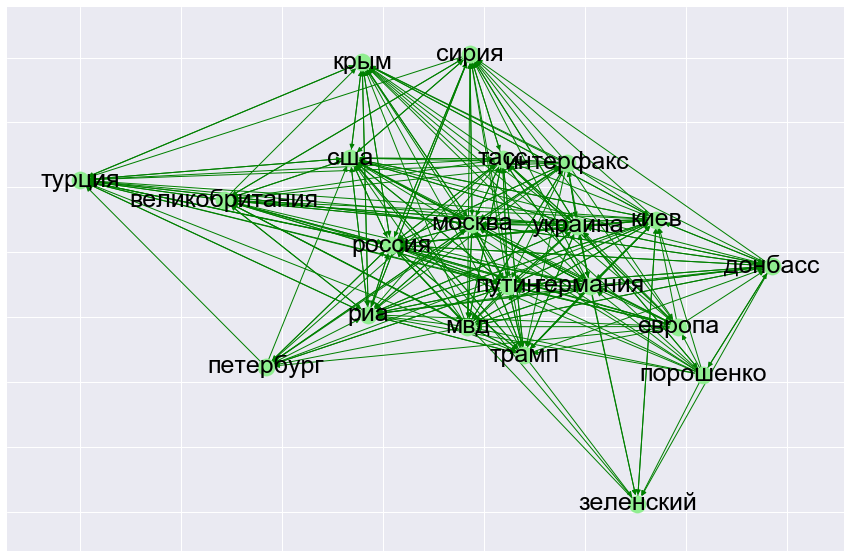

In [30]:
g = nx.DiGraph()
g.add_nodes_from(entities_set)
g.add_edges_from(list(chain.from_iterable(text_entities_new)))
plt.figure(figsize=(15, 10))
nx.draw_networkx(g, font_size=25, font_color='black', 
                 edge_color='green', node_color='lightgreen')

ВЛАДИМИР ПУТИН МОЛОДЕЦ ПОЛИТИК ЛИДЕР И БОРЕЦ!

### Получение центральной сущности и зависимых с ней сущностей

In [31]:
variable_types = {}
for entity in entities_set:
    variable_types[entity] = 'd'

In [32]:
%%time
ic_algorithm = IC(MutualInformationTest)
graph = ic_algorithm.search(df, variable_types)

CPU times: user 13min 26s, sys: 7.79 s, total: 13min 34s
Wall time: 14min 1s


Нарисуем граф с учетом inductive search

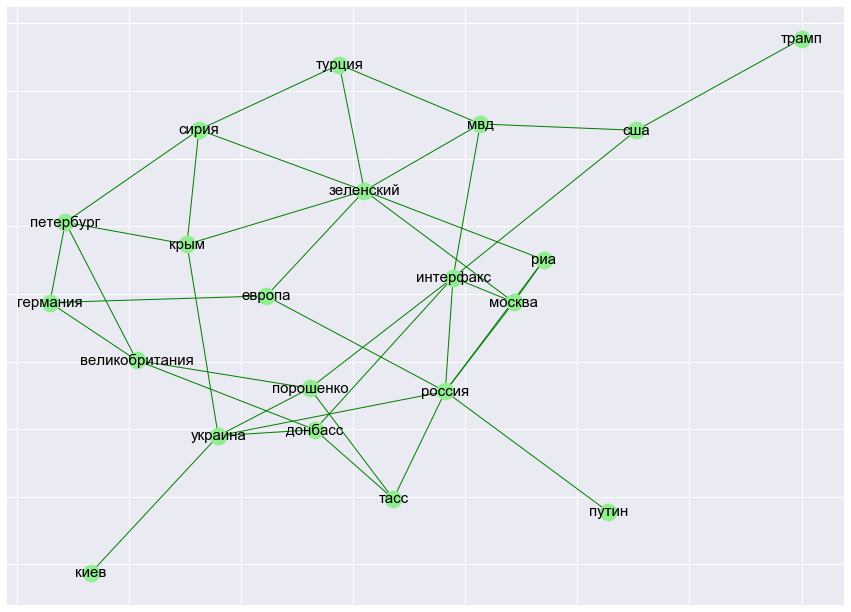

In [33]:
plt.figure(figsize=(15, 11))
nx.draw_networkx(graph, font_size=15, font_color='black', 
                 edge_color='green', node_color='lightgreen')

Все полученные ребра

In [34]:
for e in graph.edges(data=True):
    print(e)

('украина', 'россия', {'marked': False, 'arrows': ['украина', 'украина', 'украина', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия']})
('украина', 'киев', {'marked': False, 'arrows': ['украина']})
('украина', 'донбасс', {'marked': False, 'arrows': ['украина', 'украина', 'донбасс', 'донбасс', 'донбасс']})
('украина', 'порошенко', {'marked': False, 'arrows': ['украина', 'украина', 'порошенко', 'порошенко', 'порошенко']})
('украина', 'крым', {'marked': False, 'arrows': ['украина', 'украина', 'крым', 'крым', 'крым']})
('сша', 'трамп', {'marked': False, 'arrows': ['сша']})
('сша', 'мвд', {'marked': True, 'arrows': ['мвд', 'мвд', 'мвд']})
('сша', 'интерфакс', {'marked': False, 'arrows': ['сша', 'интерфакс', 'интерфакс', 'интерфакс', 'интерфакс']})
('россия', 'москва', {'marked': False, 'arrows': ['россия', 'россия', 'россия', 'москва']})
('россия', 'тасс', {'marked': False, 'arrows': ['россия', 'россия', 'россия', 'россия', 'россия', 'тасс', 'тасс']})
('россия', 'риа', {'marked': 

Запишем в entities_connections количество зависимых сущностей для каждой сущности из списка, а в entities_connections_sets множества этих зависимых сущностей.

In [36]:
entities_connections = {}
entities_connections_sets = {}

for entity in entities_set:
    temp = []
    for connection in graph.edges(data=True):
        if connection[0]==entity: 
            temp.append(connection[1])
        if connection[1]==entity:
            temp.append(connection[0])
    entities_connections[entity] = len(set(temp))
    entities_connections_sets[entity] = set(temp)

In [43]:
central_entity = max(entities_connections, key=entities_connections.get)
central_entity_connects = entities_connections_sets[central_entity]

print('Количество зависимых сущностей:\n{}\n'.format(entities_connections))
print('Центральная сущность: {}'.format(central_entity))
print('Центральная сущность зависит от сущностей: {}'.format(central_entity_connects))

Количество зависимых сущностей:
{'украина': 5, 'сша': 3, 'россия': 7, 'москва': 4, 'киев': 1, 'тасс': 3, 'трамп': 1, 'риа': 3, 'донбасс': 4, 'европа': 3, 'порошенко': 4, 'зеленский': 7, 'путин': 1, 'крым': 4, 'мвд': 4, 'сирия': 4, 'турция': 3, 'германия': 3, 'петербург': 4, 'интерфакс': 6, 'великобритания': 4}

Центральная сущность: россия
Центральная сущность зависит от сущностей: {'интерфакс', 'европа', 'тасс', 'москва', 'украина', 'риа', 'путин'}


РОССИЯ!!! РОССИЯ!!! РОССИЯ!!!

### ACE

$$ A C E =\mathbf{P}(Y=\text { центральная сущность упоминается } | d o(X=\text { упоминание сущностей, от которых она зависит }))- -\mathbf{P}(Y=\text { центральная сущность упоминается } | d o(X=\text {отсутствие упоминания сущностей, от которых она зависит }))$$

In [49]:
#adjustment = AdjustForDirectCauses()
#admissable_set = adjustment.admissable_set(graph, ['путин'], [central_entity])
#admissable_set

In [50]:
%%time
variable_types = {}
for entity in entities_set:
    variable_types[entity] = 'u'

print('ACE сущности <{}> для всех зависимых сущностей:'.format(central_entity))

for entity in central_entity_connects:
    effect = CausalEffect(df, [entity], [central_entity], 
                          variable_types=variable_types, admissable_set=[])

    mentioned = pd.DataFrame({entity: [1], central_entity: [1]})
    n_mentioned = pd.DataFrame({entity: [0], central_entity: [1]})

    print(entity, effect.pdf(mentioned) - effect.pdf(n_mentioned))

ACE сущности <россия> для всех зависимых сущностей:
интерфакс 0.13169279113652288
европа 0.1407900587651798
тасс 0.34922325789077197
москва 0.23091712301444128
украина 0.16977362649365207
риа 0.20871828797798797
путин 0.5541474152063991
CPU times: user 1.2 s, sys: 180 ms, total: 1.38 s
Wall time: 19min 51s


Как и ожидалось: ВЛАДИМИР ПУТИН МОЛОДЕЦ ПОЛИТИК ЛИДЕР И БОРЕЦ!

Оценим вручную вероятности

In [55]:
for entity in central_entity_connects:
    p_mentioned = len(df[((df[central_entity]==1) & (df[entity]==1))]) / len(df)
    p_n_mentioned = len(df[((df[central_entity]==1) & (df[entity]==0))]) / len(df)
    ACE = p_mentioned - p_n_mentioned
    print('-'*20 + '\n' + entity)
    print('P_упоминается={}\nP_не_упоминается={}\nACE={}'.format(p_mentioned, p_n_mentioned, ACE))

--------------------
интерфакс
P_упоминается=0.04375
P_не_упоминается=0.27175
ACE=-0.22799999999999998
--------------------
европа
P_упоминается=0.02225
P_не_упоминается=0.29325
ACE=-0.271
--------------------
тасс
P_упоминается=0.02625
P_не_упоминается=0.28925
ACE=-0.263
--------------------
москва
P_упоминается=0.08175
P_не_упоминается=0.23375
ACE=-0.15200000000000002
--------------------
украина
P_упоминается=0.0385
P_не_упоминается=0.277
ACE=-0.23850000000000002
--------------------
риа
P_упоминается=0.07175
P_не_упоминается=0.24375
ACE=-0.172
--------------------
путин
P_упоминается=0.04325
P_не_упоминается=0.27225
ACE=-0.22899999999999998


### Вывод

Взяли 4000 случайных новостей. Действительно подтвердилось, что данный в задаче список сущностей – это самые популярные сущности: в 66% выбранных новостей они встретились. По первому графу обычных связей "упоминается вместе в одной новости" уже было видно, что Россия, Москва, Путин и Украина в центре событий и скорее всего кто-то из них – центральная сущность. Да! По MutualInformationTest мы получили зависимые сущности – центральной оказалась РОССИЯ. Получились достаточно интересные результаты: в основном связи логичные. У Путина зависимость только от России, у Трампа только от США, Киев от только Украины и подобное. Но вот Зеленский!.. ОН ВЕЗДЕ

Получили оценки ACE для всех зависимых сущностей для России. И тут Путин не подвел – ушел в отрыв от всех остальных сущностей (высшая зависимая от России сущность). Его ACE оказался максимальным. Также оценили вероятности для подсчета ACE. Тут, конечно, Путин стал примерно на равных с интерфаксом и подобными, но порядки значений ACE примерно совпали с посчитанными ранее.

Итог: очевиден – в российских новостях центральная сущность – это Россия. Ну и ВЛАДИМИР ПУТИН МОЛОДЕЦ ПОЛИТИК ЛИДЕР И БОРЕЦ!